# DLFT versus WR benchmark 

## Test case number 01 

![TC_01](./_images/TC_01.PNG "TC_01")

| $m_{1}$ | $m_{0}$ | $k$| $c$| $g$| $k_{pen}$| $F_{ext}$|
|:-:|:-:|:-:|:-:|:-:|:-:|:-:|
| $50$ | $0$ | $1e6$ | $2e-1\sqrt{m_{1} \cdot k}$ | $2e-5$ | $1e8$ | $10$ |

In [4]:
# make generic imports 
import pyHarm
import numpy as np
from HelperFunctions import prep_fig, export_sol, get_frf, create_directory_relative, modify_input_dict, build_style
import copy 
NAME_STUDY = "TC_01"
create_directory_relative(NAME_STUDY)

from pyHarm.BaseUtilFuncs import pyHarm_plugin
from CustomDLFTUniGap import DLFTUniGap
pyHarm_plugin(DLFTUniGap)


Directory 'TC_01' created or already exists.


In [5]:
# Brut data from drawings
m1, m0 = 50., 0.
k, k_pen = 1e6, 1e8
g = 2e-5
Fext = 10.
c = 2e-1  * np.sqrt(m1*k)
epsilon_dlft = 1e8
## let's build the matrices 
M = np.diag(np.array(
    [m1,m0]
))
K = np.array(
    [
        [k,0.],
        [0.,k_pen]
    ]
)
C = np.array(
    [
        [c,0.],
        [0.,0.]
    ]
)
G = 0*C # No gyroscopic matrice

# Let's construct everything for the system to be built : 
sub_dict = dict(
    type='substructure',
    ndofs=1,
    matrix = dict(
        M = M,
        C = C,
        G = G,
        K = K
    )
)
loading = dict(
        type='CosinusForcing',
        connect=dict(sub=[0]),
        dirs=[0],
        amp = Fext
)
gap = dict(
        type='DLFTUniGap',
        connect=dict(sub=[0], INTERNAL=[1]),
        dirs=[0],
        g = -g,
        N0 = 1e-10,
        eps = epsilon_dlft,
        jac='jax'
    )

system_dict = dict(
    type='Base',
    nh = 1,
    nti = 2**(12),
    adim = dict(status=False, lc=1.0, wc=1.0)
)

basic_system_dict = dict(
    system = system_dict,
    substructures = dict(sub = sub_dict),
    connectors=dict(
        loading = loading,
        gap = gap
    )
)
from pyHarm.Elements.NodeToNodeElements.DLFTElements import DLFTUniGap
from pyHarm.Systems.FactorySystem import generateSystem
sys_test = generateSystem(system_dict['type'], basic_system_dict)
print(f"System is composed of {len(sys_test.LE)} connectors that are : ")
[print(f"- {e.__repr__()}") for e in sys_test.LE]
sys_test.expl_dofs


[   INFO   ] -- 09:55:30 -- # SYSTEM INITIALIZED :
                         |  Total dof number  |    6     |
                         |Substructures|Parts |    1     |
                         |Connectors|Elements |    3     |
                         |     Kinematics     |    0     |
                         |     Harmonics      |    1     |
                         |     Time steps     |   4096   |



System is composed of 3 connectors that are : 
- sub[Substructure]
- loading[CosinusForcing]
- gap[DLFTUniGap]


,sub,harm,cs,node_num,dof_num,PoM,NL,KC
0,sub,0,c,0,0,p,1,0
1,sub,0,c,1,0,p,1,0
2,sub,1,c,0,0,p,1,0
3,sub,1,c,1,0,p,1,0
4,sub,1,s,0,0,p,1,0
5,sub,1,s,1,0,p,1,0


In [6]:
# Build up the analysis
## analysis parameters
PULS_INF = 60.
PULS_SUP = 210.
NB_SOL_MINI = 3E3
NB_FAIL_AUTHORIZED = 12
DS_MAX = (PULS_SUP - PULS_INF) / NB_SOL_MINI
DS_MIN = DS_MAX * 2**(-NB_FAIL_AUTHORIZED)
VERBOSE = False

## modification of the system
NH = 1
NTI = 2**(12)
WC = np.sqrt(k/m1)
LC = g
ADIM = False

## analysis dico : 
frf_dict = dict(
    study='frf',
    puls_inf = PULS_INF,
    puls_sup = PULS_SUP,
    ds_max = DS_MAX,
    ds_min = DS_MIN,
    ds0 = DS_MAX,
    verbose=VERBOSE
)

In [7]:
# Run the basic linear solution first
input_dict = dict(
    analysis = dict(
        FRF = frf_dict
    ),
    system = system_dict,
    substructures = dict(
        sub = sub_dict
    ),
    connectors=dict(
        loading = loading, # just loading for the linear system
    )
)
L = pyHarm.Maestro(input_dict)
L.operate()


######################################################
##                                                  ##
##                                                  ##
##                  _   _                           ##
##      _ __  _   _| | | | __ _ _ __ _ __ ___       ##
##     | '_ \| | | | |_| |/ _` | '__| '_ ` _ \      ##
##     | |_) | |_| |  _  | (_| | |  | | | | | |     ##
##     | .__/ \__, |_| |_|\__,_|_|  |_| |_| |_|     ##
##     |_|    |___/                      v-1.1.3    ##
##                                                  ##
##                                                  ##
######################################################
    python      :   3.13.2              
    licence     :   Apache 2.0 - open-source
    extensions  :   


[   INFO   ] -- 09:55:32 -- # SYSTEM INITIALIZED :
                         |  Total dof number  |    6     |
                         |Substructures|Parts |    1     |
                         |Connectors|Elements |    2     |
  

In [ ]:
def mid(*args):
    return modify_input_dict(*args)
# Run the basic nonlinear solution then
## modifications for frf parameters
modif_frf = dict()
## modifications for system parameters
NH_NL = 20 + 40
NH_NL = [0] + [i for i in range(1,NH_NL,2)]
EPSILON_DLFT = 3e8
SIGN_DS = +1


input_dict_NL = dict(
    analysis = dict(
        FRF = mid(
            frf_dict,
            dict(
                verbose=True,
                sign_ds = SIGN_DS,
                reductors = [dict(type='NLdofs')],
                solver="NewtonRaphson",
                solver_options=dict(
                    max_iter=600,
                    # momentum=1e-1
                )
                # dict(type='globalHarmonic', err_admissible=1e-3) pour avoir la conservation d'harmoniques possible de faire 
                # h_always_kept = np.ararnge(1,NH+1,2) pour avoir que les harmoniques impaires voir documentation
            )
        )
    ),
    system = mid(system_dict, dict(nh=NH_NL, adim=dict(status=True, lc=LC, wc =WC))),
    substructures = dict(
        sub = sub_dict
    ),
    connectors=dict(
        loading = loading, # just loading for the linear system
        gap = mid(
            gap,
            dict(eps=EPSILON_DLFT),
        )
    )
)
NL = pyHarm.Maestro(input_dict_NL)
NL.operate()



######################################################
##                                                  ##
##                                                  ##
##                  _   _                           ##
##      _ __  _   _| | | | __ _ _ __ _ __ ___       ##
##     | '_ \| | | | |_| |/ _` | '__| '_ ` _ \      ##
##     | |_) | |_| |  _  | (_| | |  | | | | | |     ##
##     | .__/ \__, |_| |_|\__,_|_|  |_| |_| |_|     ##
##     |_|    |___/                      v-1.1.3    ##
##                                                  ##
##                                                  ##
######################################################
    python      :   3.13.2              
    licence     :   Apache 2.0 - open-source
    extensions  :   


[   INFO   ] -- 09:57:21 -- # SYSTEM INITIALIZED :
                         |  Total dof number  |   120    |
                         |Substructures|Parts |    1     |
                         |Connectors|Elements |    3     |
  

LinAlgError: Matrix is singular.

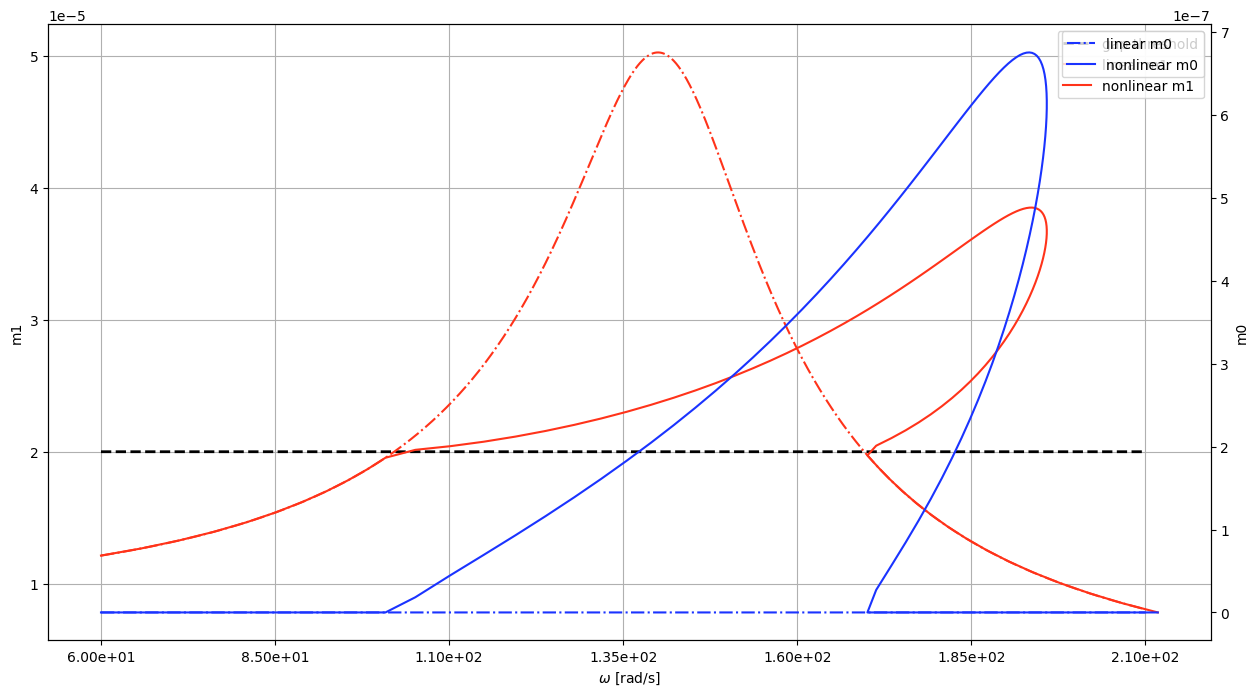

In [9]:
Lres_m1 = get_frf(L, sub='sub', node=0)
Lres_m0 = get_frf(L, sub='sub', node=1) # The inversion IS normal here
NLres_m1 = get_frf(NL, sub='sub', node=0)
NLres_m0 = get_frf(NL, sub='sub', node=1) # The inversion IS normal here

Lplt = dict(linestyle='-.', label='linear')
NLplt = dict(linestyle='-', label='nonlinear')
m1plt = dict(color=(1.0, 0.2, 0.1), label='m1')
m0plt = dict(color=(0.1, 0.2, 1.0), label='m0')
thresholdplt = dict(linestyle='--', linewidth=2, color=(0.0, 0.0, 0.0), label='gap threshold')

fig,ax = prep_fig(fp=np.linspace(PULS_INF, PULS_SUP,7))
ax_m0 = ax.twinx()
ax.plot(Lres_m1[0],g*np.ones(Lres_m1[0].shape), **build_style(thresholdplt))
ax.plot(*Lres_m1, **build_style(Lplt, m1plt))
ax_m0.plot(*Lres_m0, **build_style(Lplt, m0plt))
ax.plot(*NLres_m1, **build_style(NLplt, m1plt))
ax_m0.plot(*NLres_m0, **build_style(NLplt, m0plt))
ax.legend()
ax_m0.legend()
ax.set_ylabel('m1')
ax_m0.set_ylabel('m0')
ax.set_xlabel('$\omega$ [rad/s]')


export_sol(L, path='./TC_01', prefix=f"linear")
export_sol(NL, path='./TC_01', prefix=f"nonlinear")